## HARPS-N Solar Data Neural Networks Code

written by Zoe L. de Beurs 

See [de Beurs, Zoe L., Vanderburg, A., Shallue, C.J., et al. (2022)](https://iopscience.iop.org/article/10.3847/1538-3881/ac738e/pdf) for more details 

## Imports

In [81]:
! pip install tensorflow_addons

In [82]:
# import needed packages
import os.path
import numpy as np

#Ensures we use Tensorflow 1.x
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_addons as tfa
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

#from google.colab import files
import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from sklearn.linear_model import Ridge

2.10.0


In [ ]:
# ! git clone https://github.com/zdebeurs/rv_net

In [83]:
# rv_net imports.
import sys
sys.path.append("rv_net/")
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps
#from ridge_regress_harps import ridge_regress_harps
#from load_dataset_ridge import load_dataset_ridge

import matplotlib as mpl

## Reading in the data (June 29, 2021)


In [84]:
eval_method ='cross_val' #"cross_val" # "val" # "test"

ccf_len = 46     # number of data points

In [ ]:
# Change this path to point towards the location of the files on your device

# !ls 'Archive_HARPS_N_NEW DRS/TF_records_Nov2021'

By changing the Data Directory, you can choose where it views the files from

In [85]:
# Read in files for cross-validation
DATA_DIR = 'TF_records/TF_records_June2023-newFeatures-1/' #TF_record_July_10_21_no_planets_median_prov_rvs/' #HARPS-N Solar Telescope Data (using old DRS)/' #TF_record_July_10_21_no_planets_same_test_set' #TF_record_July_10_21_no_planets_v2'

if eval_method =="cross_val":
    # get all data file names
    data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
    # change them all to numpy arrays
    data_files = [t.numpy() for t in data_files]
    TRAIN_FILE_NAME_LIST = []    # list of training points
    VAL_FILE_NAME_LIST = []      # list of cross valuation points

    N = len(data_files)
    for i in range(N):
        val_files = [data_files[i]]
        #print(val_files)
        VAL_FILE_NAME_LIST.append(val_files)
        train_files = data_files[0:i] + data_files[i+1:]
        TRAIN_FILE_NAME_LIST.append(train_files)
        # add all the training files

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
    

elif eval_method =="test":
    TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
    VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]

    NUM_TRAINING_EXAMPLES = 503
    NUM_VALIDATION_EXAMPLES = 61
else:
    print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

In [ ]:
# print(TRAIN_FILE_NAME_LIST)
# VAL_FILE_NAME_LIST

## Feature Changing

By editing the code in _example_parser(), you can change the features that are inputted into the Neural Network

* Add the name of the feature in _example_parser()
* Add the variable name into the data_fields dictionary
* Rerun _example_parser() and load_dataset()   (in same cell below)
* Rerun the train() function below

In [86]:
# @title Data loader
def _example_parser(serialized_example):
    """
    Parses a single tf.Example into feature and label tensors.
    
    Returns
    -------
    CCF features
    RV signal
    BJDs
    New Feature
    """
    feature_name = "Rescaled CCF_residuals_cutoff"    #"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"                    #"RV",
    label2_name = "BJD"
    
    #edited in features
    test1_name = "contrast"
    test2_name = "fwhm"
    test3_name = "bis"
    
    newFeat1_name = "tsi_1au"
    
    # Which additional feature will be included
    # OTHER_FEAT = None
    Other_feat = test3_name
    
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
        Other_feat: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    

    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name], parsed_fields[Other_feat]

#def load_dataset(file_pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
#  filename_dataset = tf.data.Dataset.list_files(file_pattern)
#  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
#  if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
#  dataset = dataset.map(_example_parser, num_parallel_calls=4)
#  dataset = dataset.batch(batch_size)
#  return dataset

def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    """
    Reads in dataset
    """
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    return dataset

## Neural Network Models

Here there are three Neutral network models defined.

* The Linear Model - Very basic, just one unit in the hidden Dense layer
* The FC Model - Number of units in Dense layer given by the hyper parameters
* The CNN Model - Includes convolutional layers (as well as Dense layers) which allow you to specify which features are likely to be more useful, rather than the NN doing it on its own


In [87]:
from tensorflow.keras import layers

In [93]:
# @title Define LinearModel, FCModel, CNNModel
class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        
        # create a layer in the NN
        # number of units from hparams
        # activation using relu function  (0 for -ve x, linear for +ve x)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        
        # one output layer
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False, other_input=None):
        """
        features:
            CCF features
        training: boolean
            Default is False.
        other_input:
            Default is None.
            So that it is compatible with the changes made to call() function for the CNN
        
        """
        net = tf.expand_dims(features, -1)
        batch_size, length, depth = net.shape
        net = tf.reshape(net, [batch_size, length*depth])
        for dense in self.dense_layers:
            net = dense(net)
        net = self.output_layer(net)
        return tf.squeeze(net)

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        # This is ran when the class CNNModel() is first initialised
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        # convolutional layers
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, other_input=None, training=False):
        """
        This is ran when the class CNNModel() is called
        
        other_input:
            Additional feature to add into the NN
        """
        
        # Get the input
        net = tf.expand_dims(features, -1)
        
        # Make the convolutional network
        for conv in self.conv_layers:
            net = conv(net)
        batch_size, length, depth = net.shape
        
        # Reshaping
        # net = tf.reshape(net, [batch_size, length*depth])
        net = layers.Flatten()(net)
        
        # max-pooling layers
        
        
        # Adding new feature into the Dense layer input
        if other_input != None:
             # Concatenate the 
            
            other_input = layers.Flatten()(other_input)
            arr_of_all_branch_outputs = [net, other_input]
            concat_all = layers.concatenate(arr_of_all_branch_outputs, name='Concatenated_all')

            # Flatten / reshape
            net = layers.Flatten()(concat_all)

        
        for dense in self.dense_layers:
            net = dense(net)
        net = self.output_layer(net)
        return tf.squeeze(net)

## Prediction function and Training the NN

Can use train_no_logging() to train the NN without logging the values?


In [97]:
def make_predictions(model, dataset):
    all_preds = []
    all_labels = []
    all_bjds = []
    for features, labels, bjds, new_features in dataset:
        # extract the feature and look at how the bjd's are being used in the function
        # feed into the model
        
        preds = model(features, training=False, other_input=new_features)
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())
        all_bjds.append(bjds.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

In [98]:
def train(model, hparams, plots, model_name, num_epochs):#=100):
    """
    Trains the Neural Network given a specific model
    
    Parameters
    ----------
    model:
        Neural Network Model. It is one of the NN classes, for example CNNModel() or FCModel() object.
    hparams: dict
        Dictionary of the various hyperparameters being used
    plots: str
        if plots is "ON", makes plots. if plots is "OFF" (or anything else), does not make plots
    model_name: str
        Name of the model. "FC NN" or "CNN"
    num_epochs: int
        Number of epochs to run model for
        
    Returns
    -------
    
    
    """
    
    # get the training dataset
    train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
    # get the validation dataset
    val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
    
    # create the loss function model
    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
    # create the optimizing model
    Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
    # create the optimizer
    optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
    metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
    ]
    weight_decay_list_t.append(hparams.weight_decay)
    gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

    metric_values = []
    for epoch in range(1, num_epochs+1):
        # Reset metric values for each new epoch.
        for m in metrics:
            m.reset_states()

        # Train over all batches in the training set.
        for features, labels, bjds, new_features in train_dataset:
            if hparams.gaussian_noise_scale:
                features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
                #print(hparams.gaussian_noise_scale)
            
            # One training step.
            with tf.GradientTape() as t:
                
                # e.g. CNNModel(). We are calling it so it is calling the call() function.
                # other_input: The new feature being added that is going into a different level of the CNN
                preds = model(features, training=True, other_input=new_features)
                
                loss = loss_fn(labels, preds)
                
            
            grads = t.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Update the metrics.
            for m in metrics:
                m(labels, preds)
    
        # End of an epoch.
        epoch_metrics = {"epoch": epoch}
        # First, log the training metrics.
        for m in metrics:
            epoch_metrics[m.name] = m.result().numpy()
            

        # Next, evaluate over the validation set.
        labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
        epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Add a metric for the raw scatter started with
        epoch_metrics["original_rmse"] = np.std(labels_val)
        # Add a metric for raw scatter - corrected scatter
        epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
        # Log metrics to tensorboard.
        for metric, value in epoch_metrics.items():
            tf.summary.scalar(metric, value, step=epoch)
        epoch_metrics["epoch"] = epoch
        # Print metric values at selected epochs.
        if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
        metric_values.append(epoch_metrics)

    # Gather predictions
    labels, preds, bjd = make_predictions(model, train_dataset)
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    all_bjds_val.append(bjd_val)
    bjd_run_val.append(bjd_val)
    all_pred_val.append(preds_val)
    pred_run_val.append(preds_val)
    all_labels_val.append(labels_val)
    labels_run_val.append(labels_val)

    # Scatter reduction plot
    sd_x = np.std(labels_val, ddof=1)
    rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
    rms_x_list.append(rms_x)
    rms_avg_list.append(rms_x)
    stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
    x_range = np.linspace(-4,5.5, 17)
    upper_bound = x_range+rms_x
    lower_bound = x_range-rms_x

    if plots=="ON":
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        ax = axes[0]
        ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
        ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper right")

        # Gather predictions to plot against labels.
        ax = axes[1]
        ax.plot(preds, labels, ".", label="Training")
        ax.plot(preds_val, labels_val, ".", label="Validation")
        ax.set_xlabel("Actual Y")
        ax.set_ylabel("Predicted Y")
        ax.legend(loc="lower right")

        # plot the scatter reduction plot
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(labels_val, preds_val, ".")
        ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
        #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
        rms_fill=rms_x#0.15
        ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
        ax1.set_xlim(-4, 4);
        ax1.set_ylim(-4, 4);
        ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
        ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
        ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
        #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
        ax1.legend(loc="lower right")
    else:
        textstr = '\n'.join((
            r'Raw scatter=%.3f m/s' % (sd_x, ),
            r'Corrected scatter=%.3f m/s' % (rms_x, ),
            r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
        print(textstr)
    
    return metric_values


## FC NN Model Run

1: Train loss: 3.435, Train RMSE: 1.831, Val RMSE: 1.566
10: Train loss: 1.959, Train RMSE: 1.371, Val RMSE: 1.281
20: Train loss: 1.423, Train RMSE: 1.181, Val RMSE: 1.23
30: Train loss: 0.9267, Train RMSE: 0.9721, Val RMSE: 1.279
40: Train loss: 0.6042, Train RMSE: 0.7305, Val RMSE: 1.284
50: Train loss: 0.3589, Train RMSE: 0.6487, Val RMSE: 1.254
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.469, Train RMSE: 1.816, Val RMSE: 1.817
10: Train loss: 1.845, Train RMSE: 1.393, Val RMSE: 1.523
20: Train loss: 1.166, Train RMSE: 1.11, Val RMSE: 1.332
30: Train loss: 0.8897, Train RMSE: 0.9457, Val RMSE: 1.235
40: Train loss: 0.5875, Train RMSE: 0.7761, Val RMSE: 1.254
50: Train loss: 0.3003, Train RMSE: 0.5783, Val RMSE: 1.18
________________________
Cross-val number: 2, Run number: 1
1: Train loss: 3.073, Train RMSE: 1.777, Val RMSE: 2.032
10: Train loss: 1.874, Train RMSE: 1.356, Val RMSE: 1.245
20: Train loss: 1.228, Train RMSE: 1.101, Val RMSE: 1.284
30: 

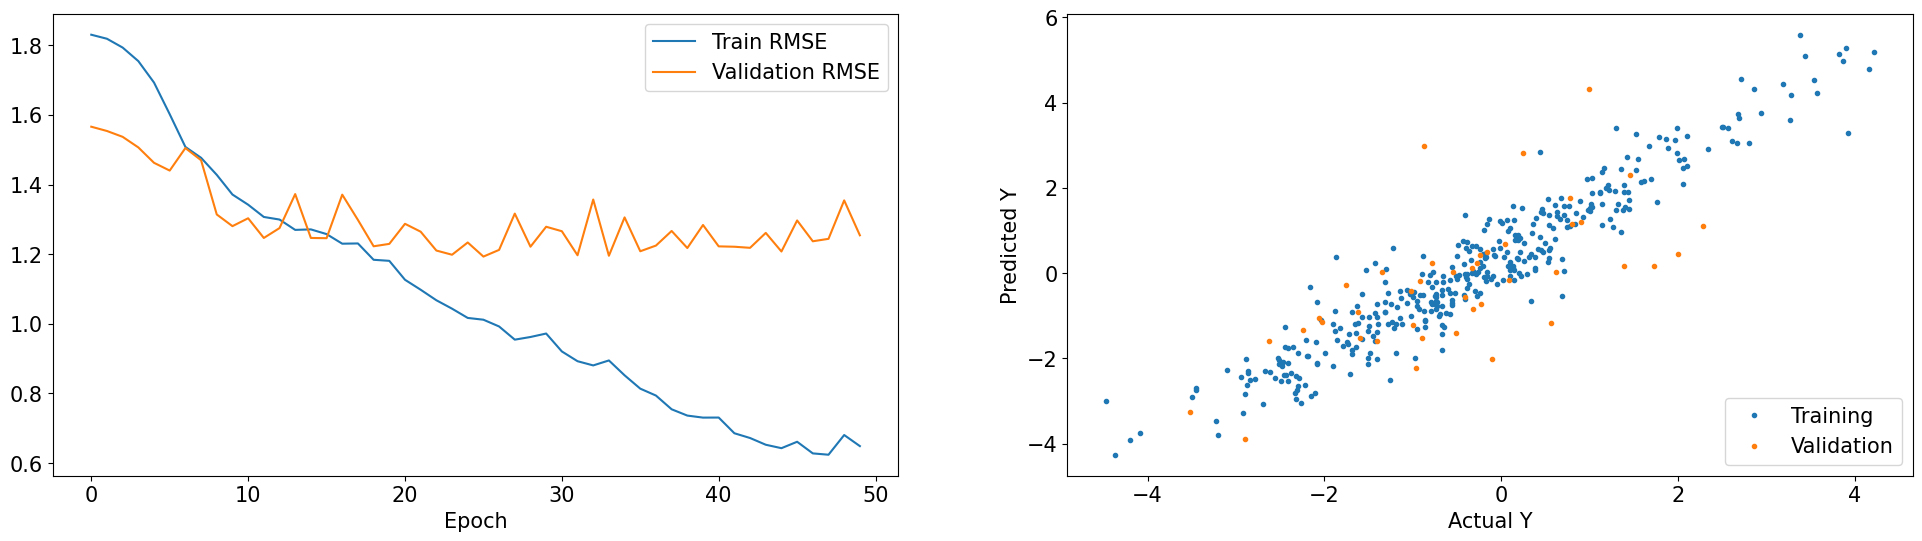

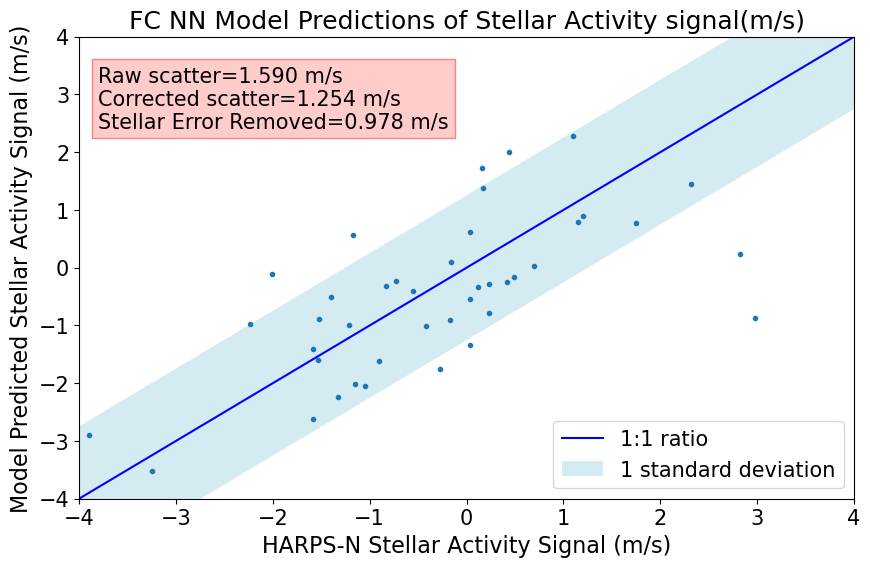

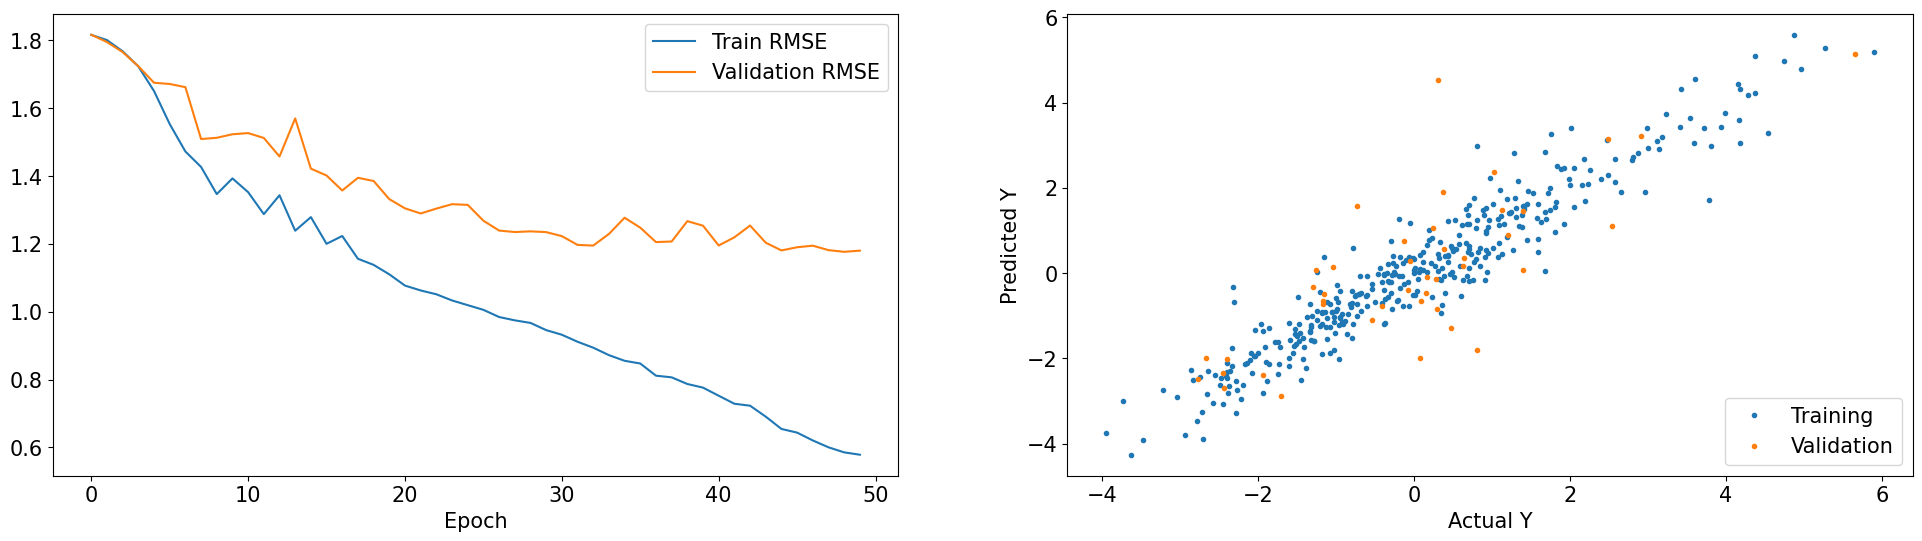

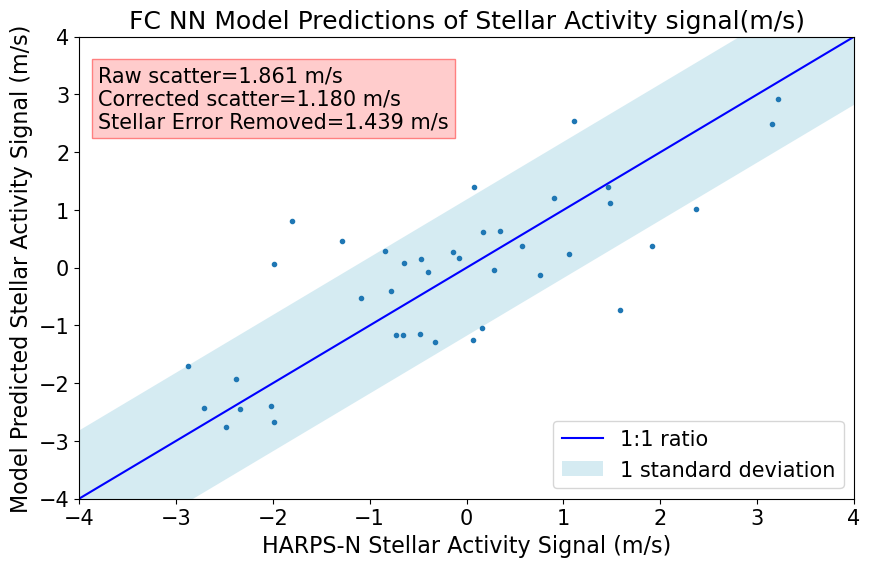

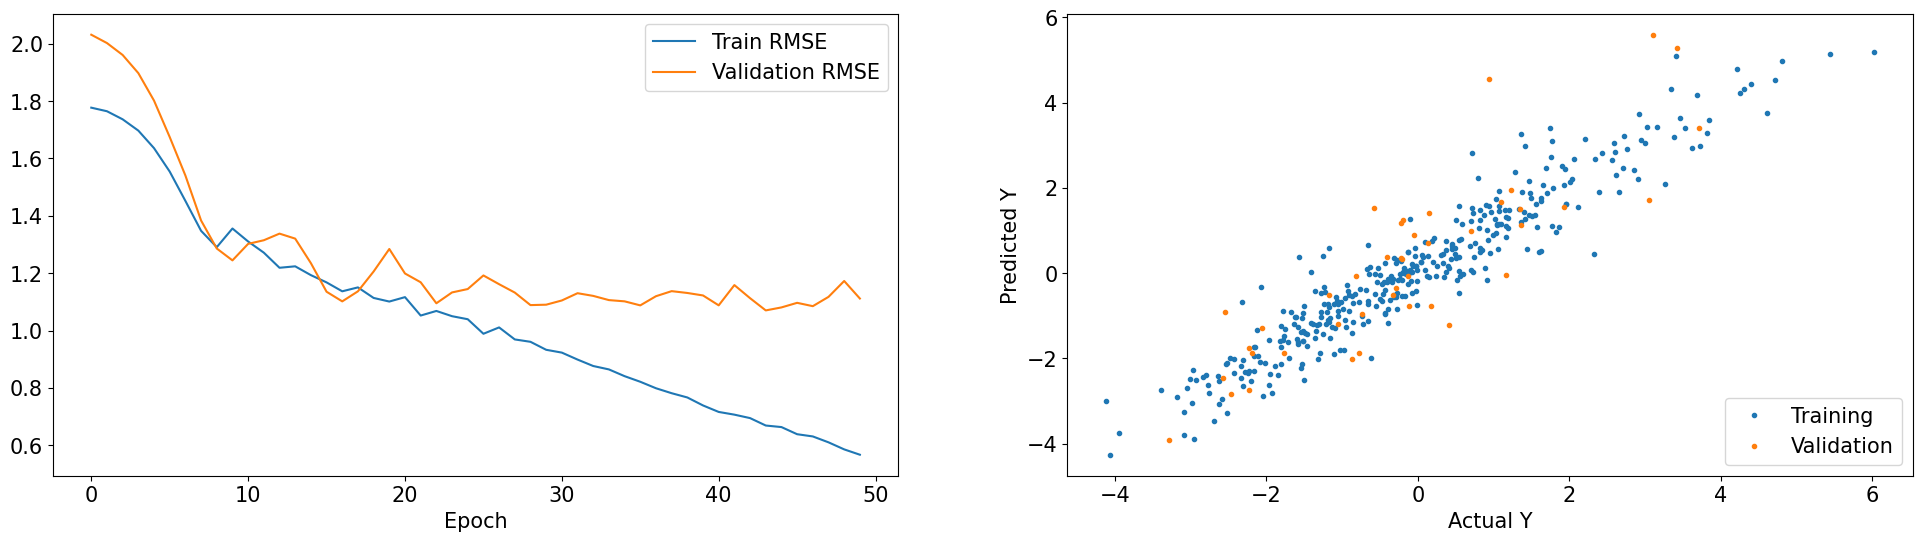

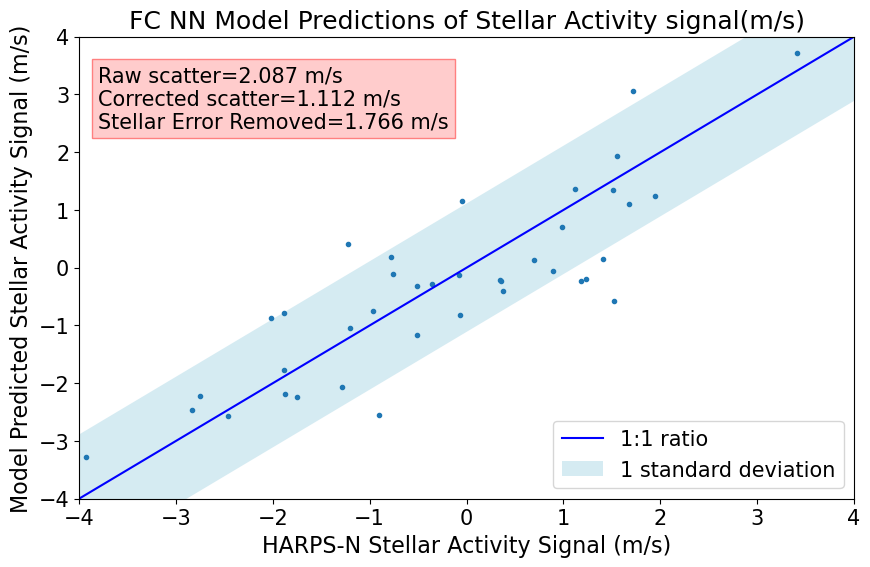

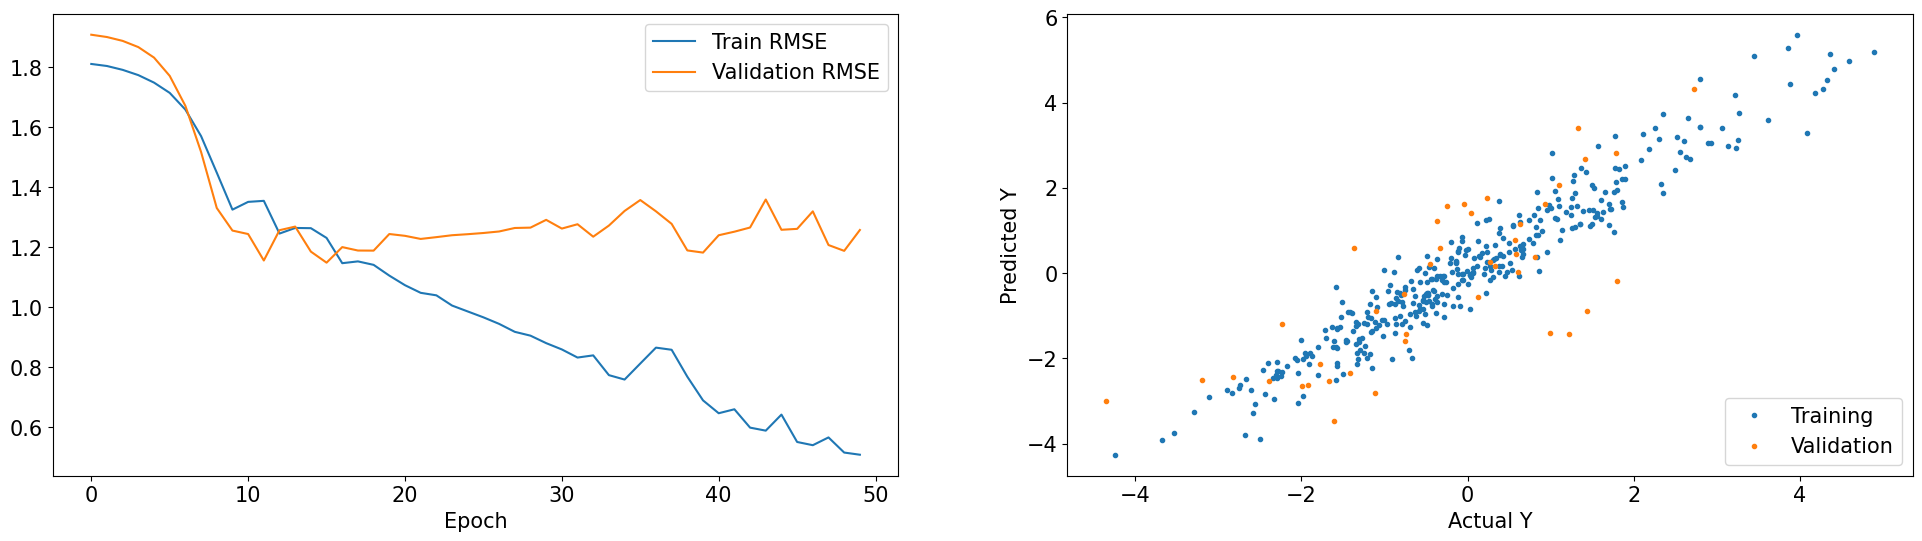

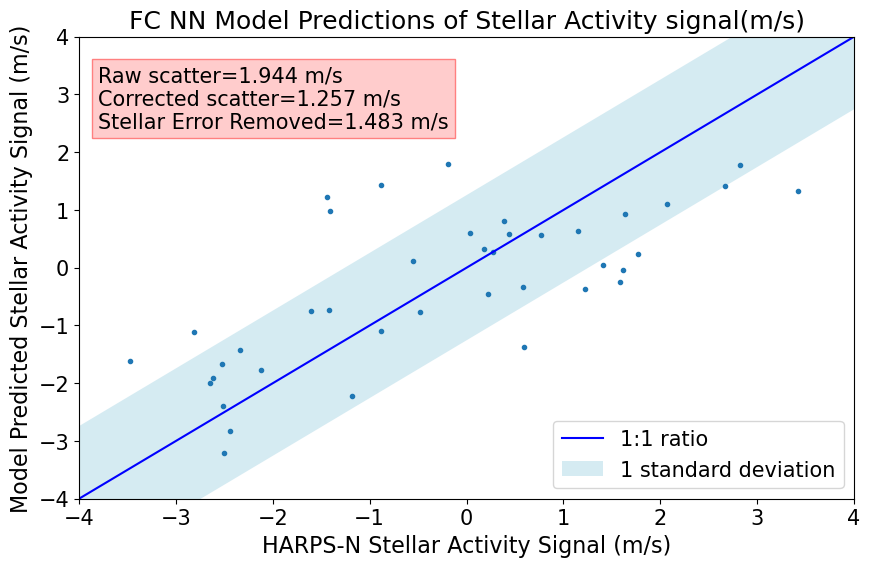

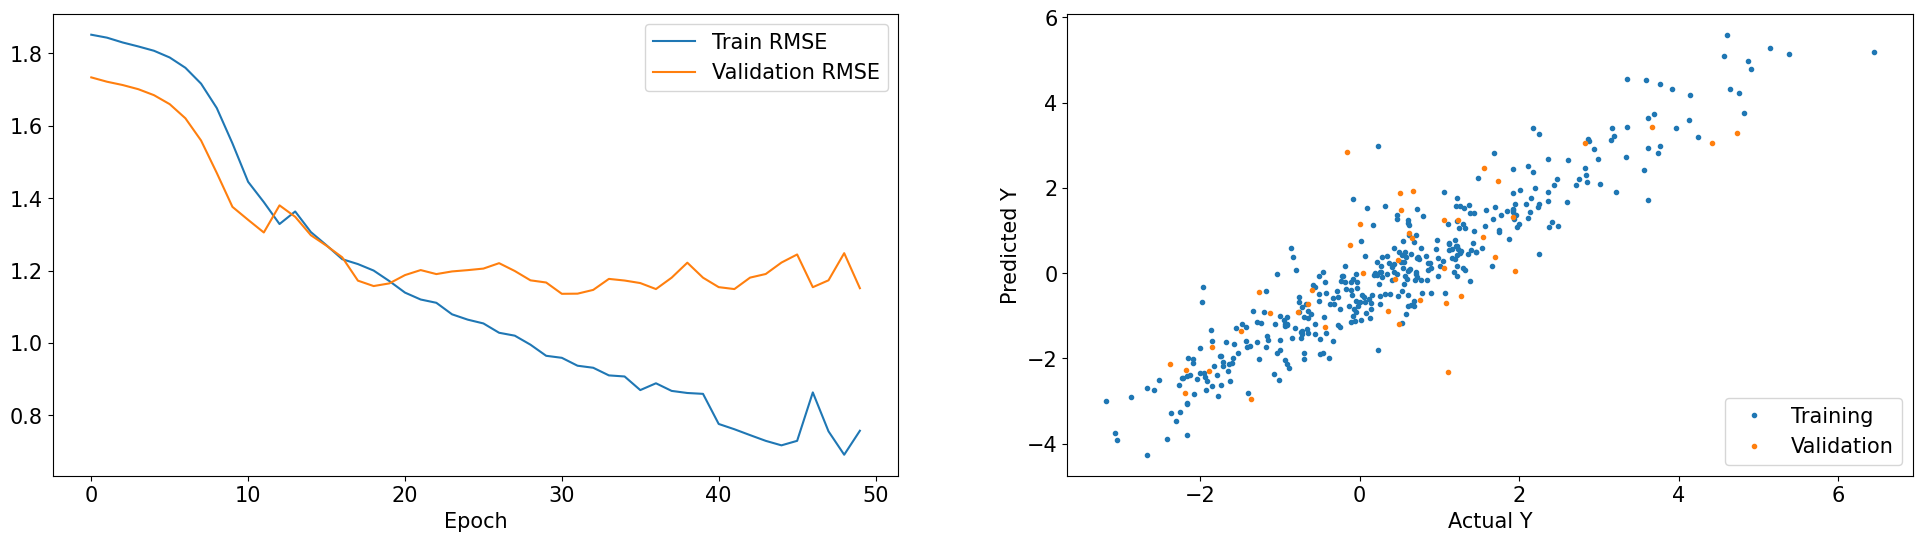

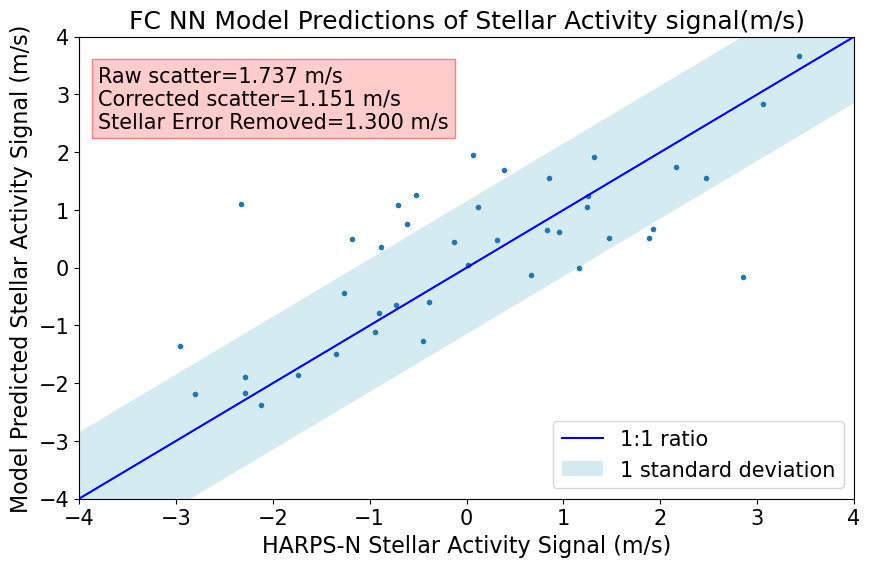

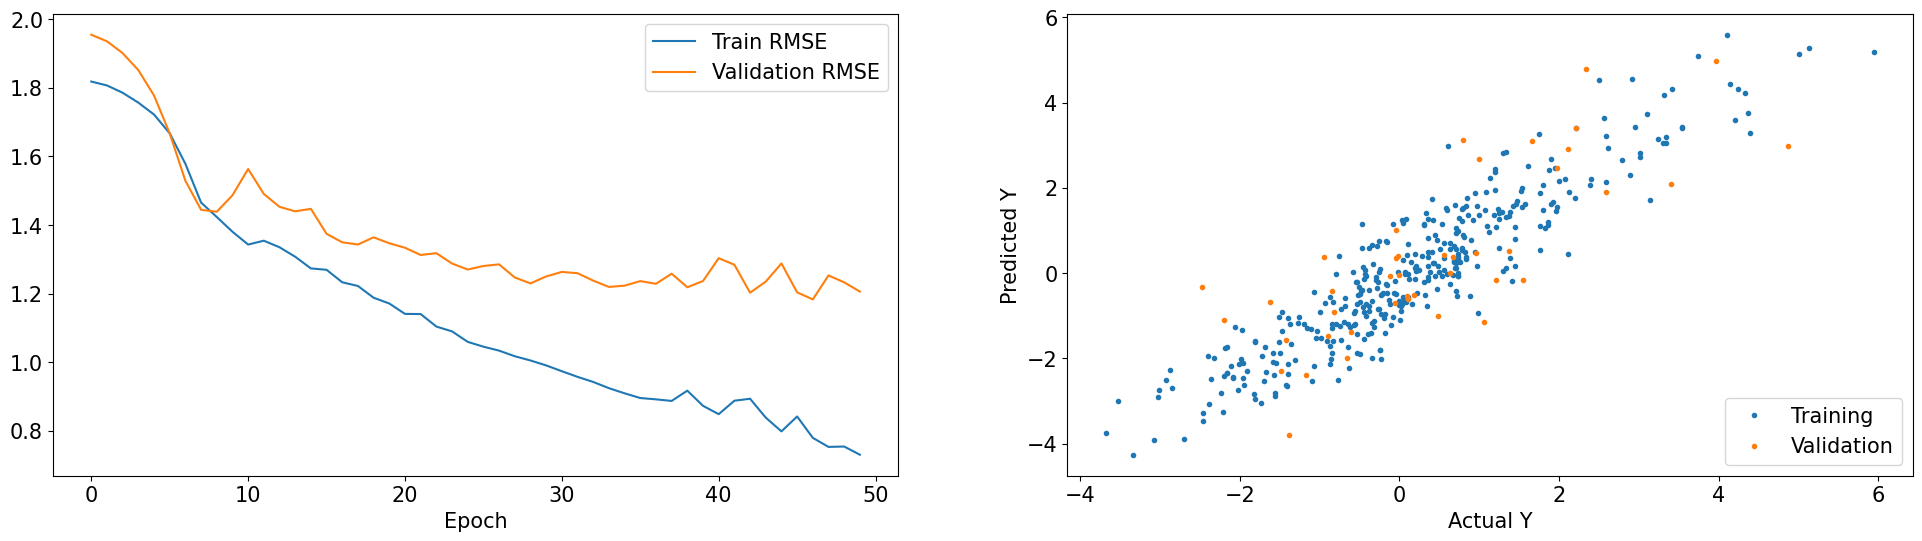

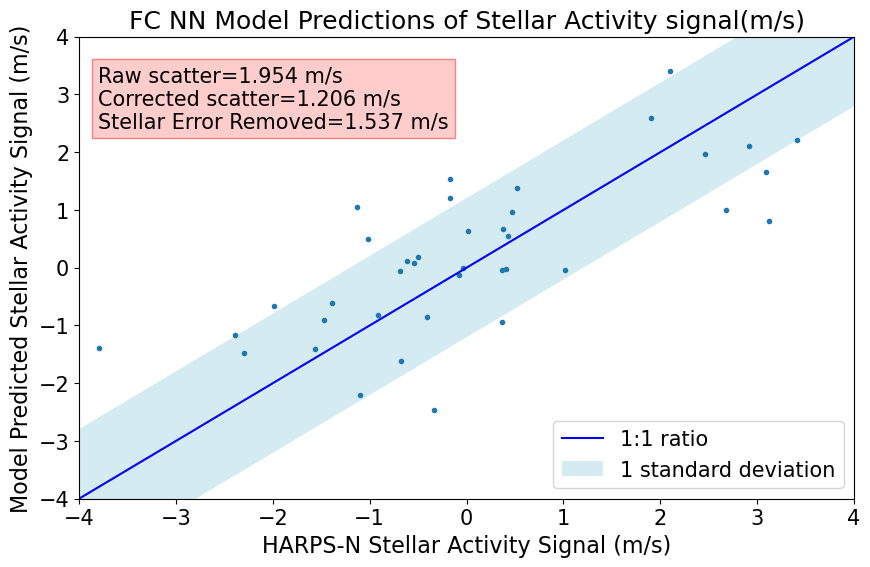

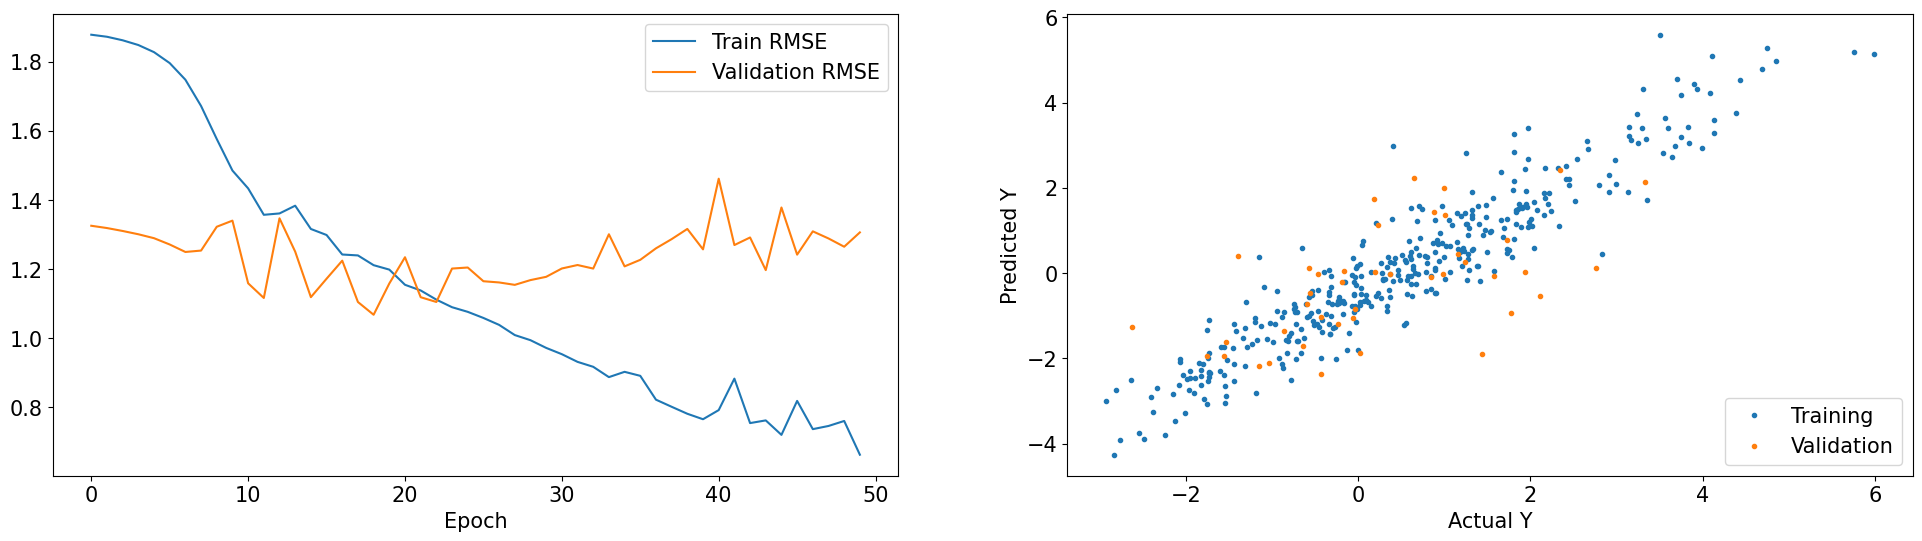

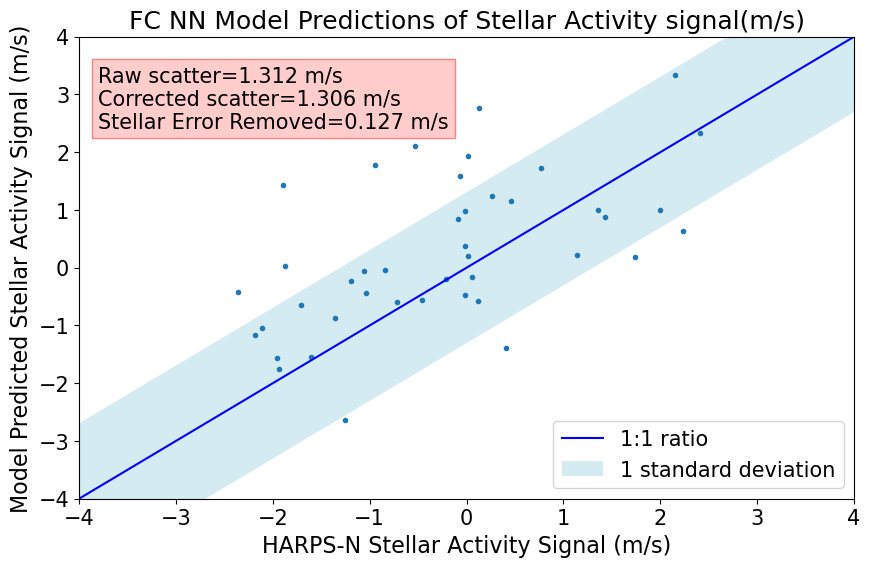

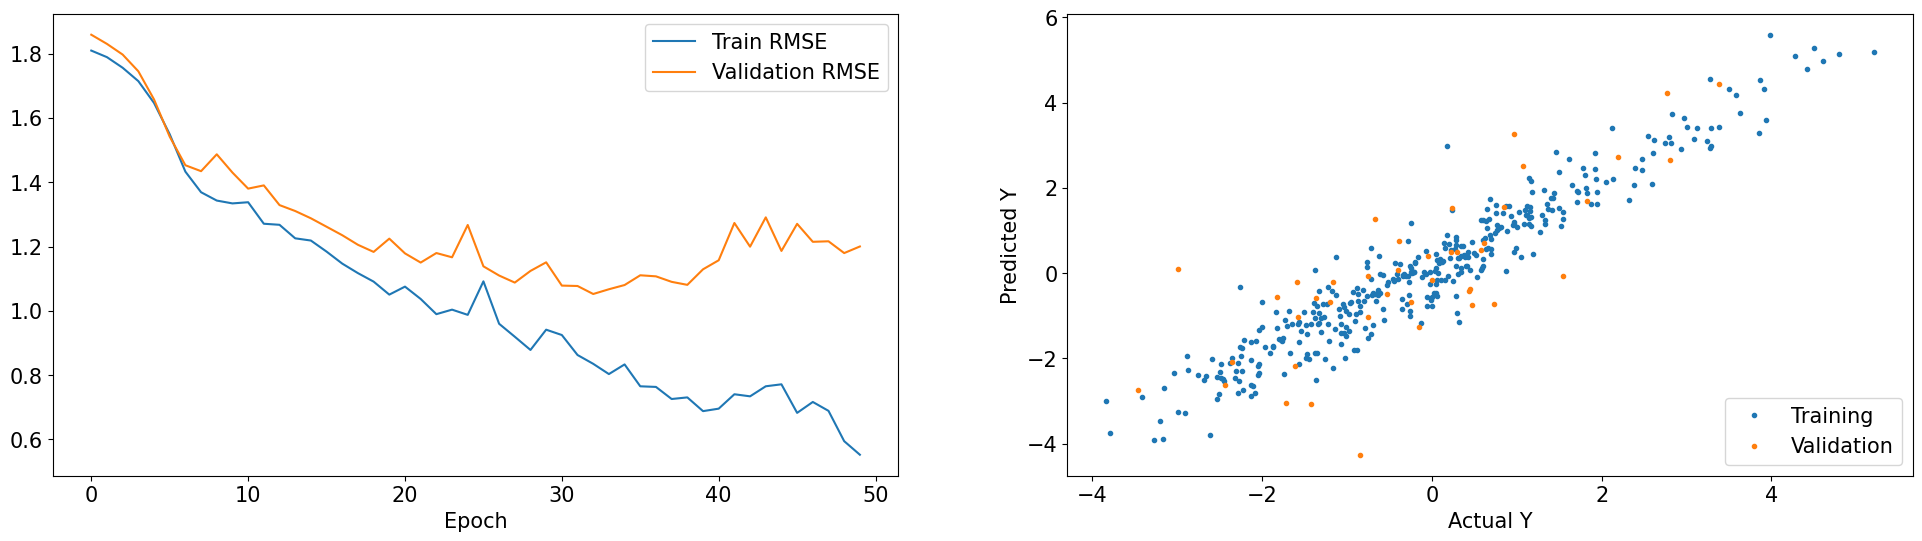

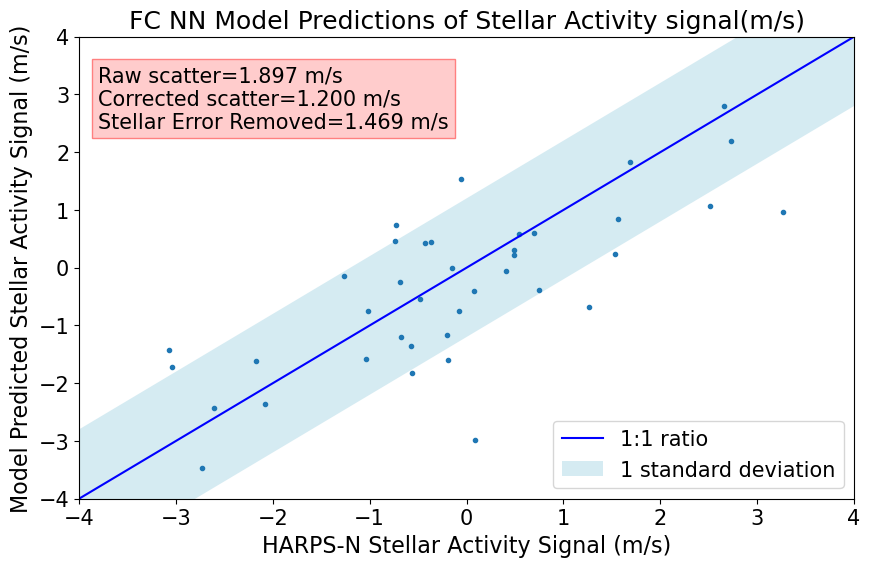

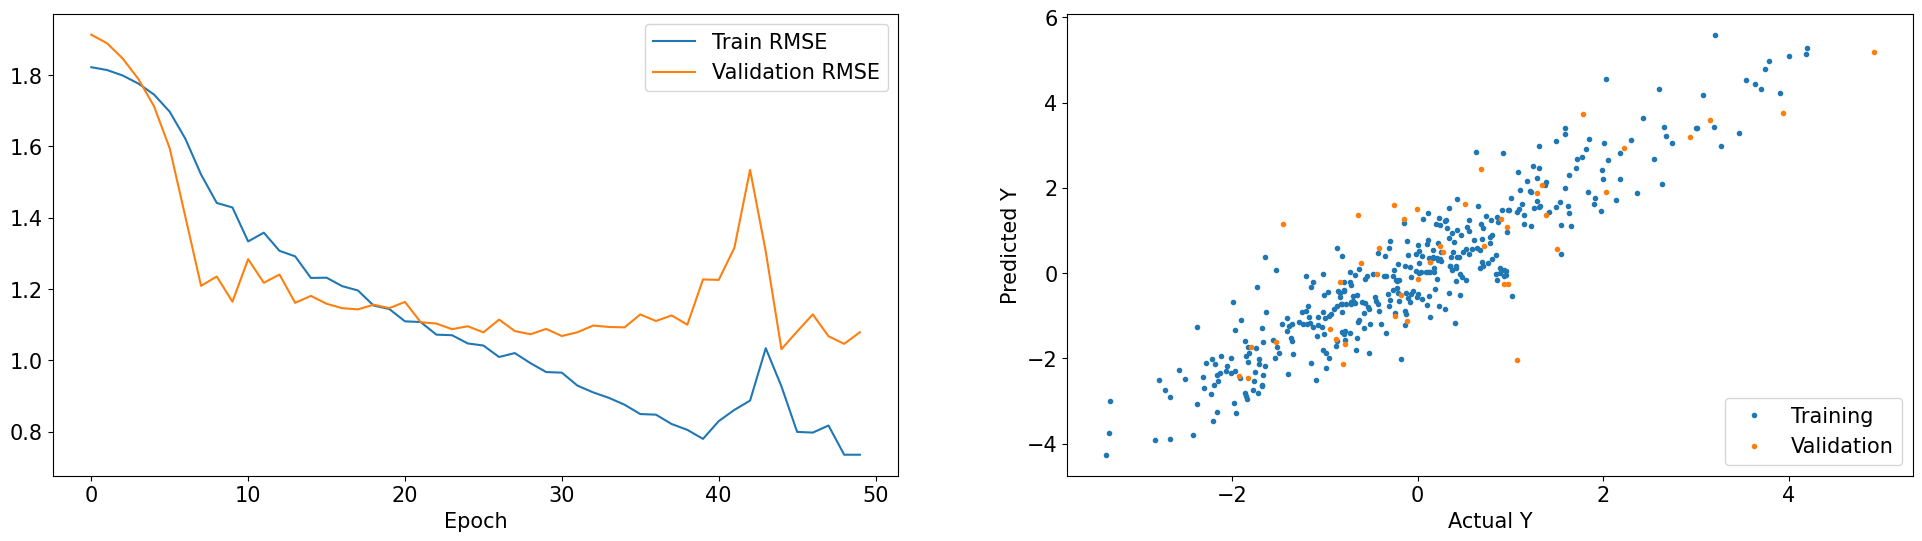

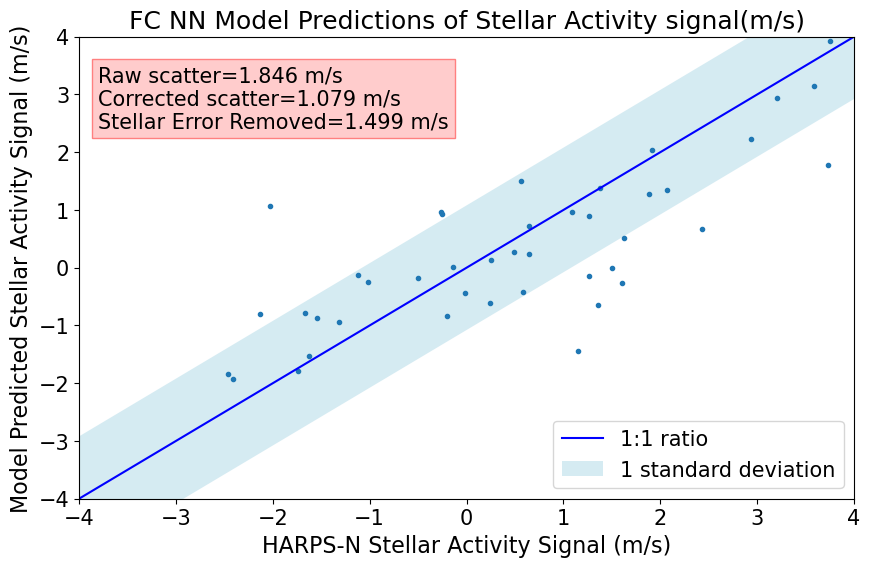

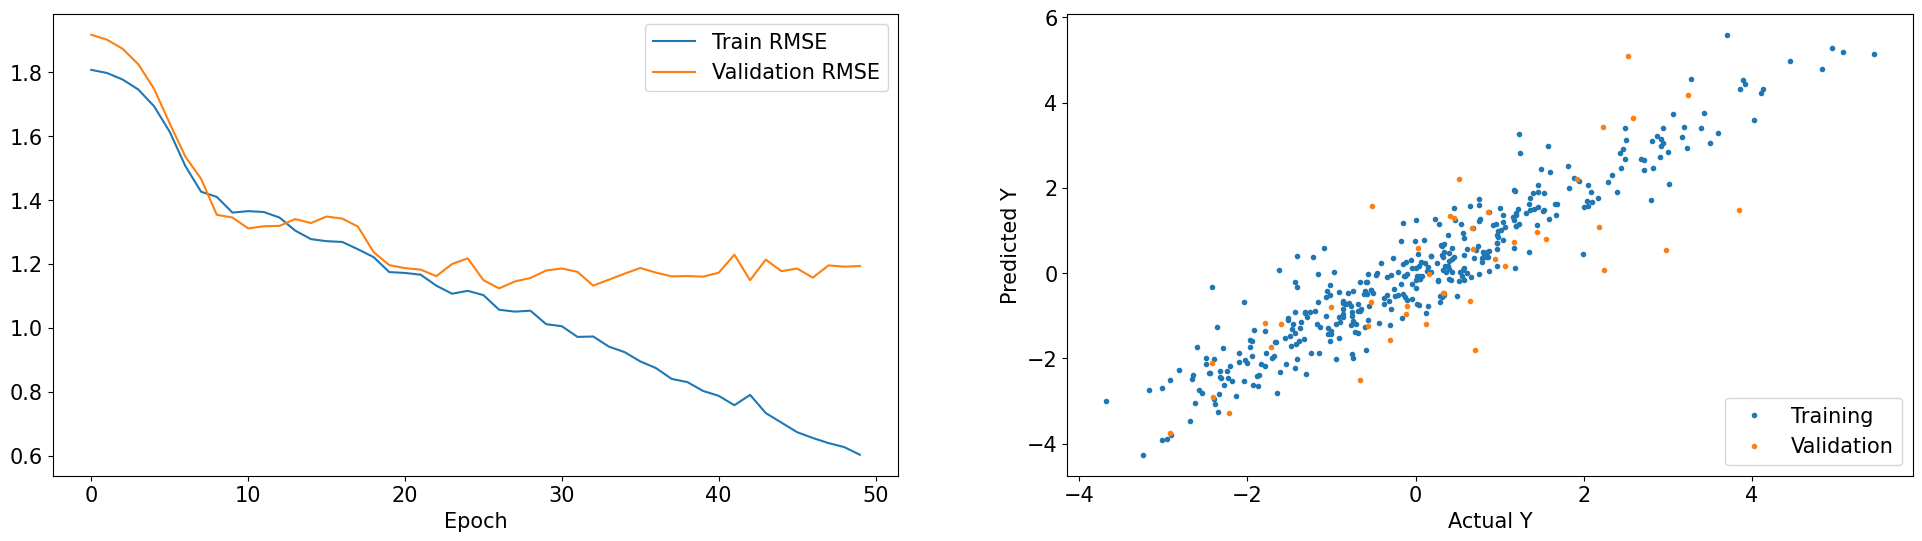

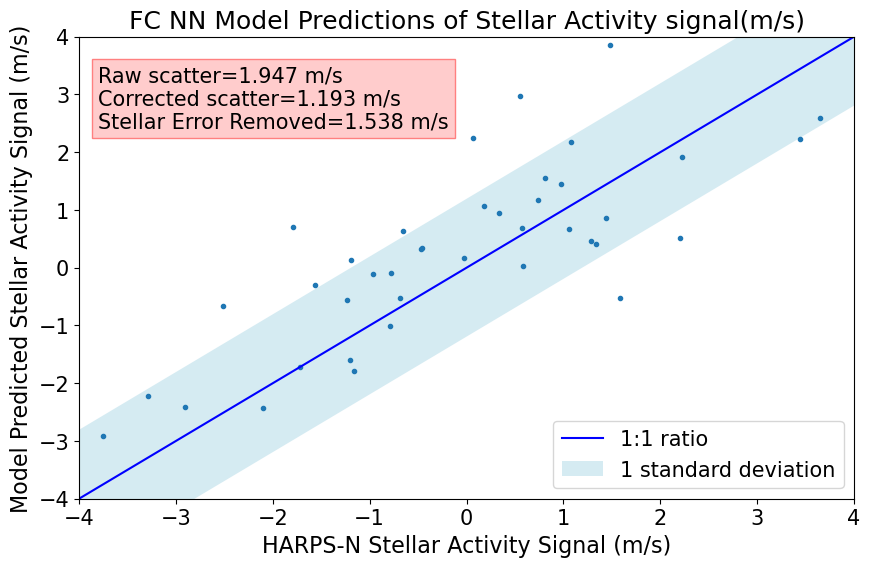

In [101]:
# FC NN Model run

# Cross validation Linear NN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,1):#0): #should be 10 for a full run
        hparams = configdict.ConfigDict(dict(
          num_features=152,#161,
          learning_rate=0.0054042, #0.040267, #0.0095352,#0.0016077,
          momentum=0.9,
          batch_size=300,
          num_dense_units=100,#1000,#200,
          num_dense_layers=8, #4,
          weight_decay=0.00010000,#0.008000,#0.00010000, #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5, 
        ))
        model = FCModel(hparams)
        train(model, hparams, plots="ON",model_name="FC NN", num_epochs=50)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

labels: sd: 1.8284893255600085
corrected rv: sd: 1.1966619441204642
____________________________________________
labels: MAD*1.4826: 1.7439014172434806
corrected rv: MAD*1.4826: 1.1204399120628834
____________________________________________
labels: 68 percent/2: 1.7452754235267638
corrected rv: 68 percent/2: 1.1157387042045595


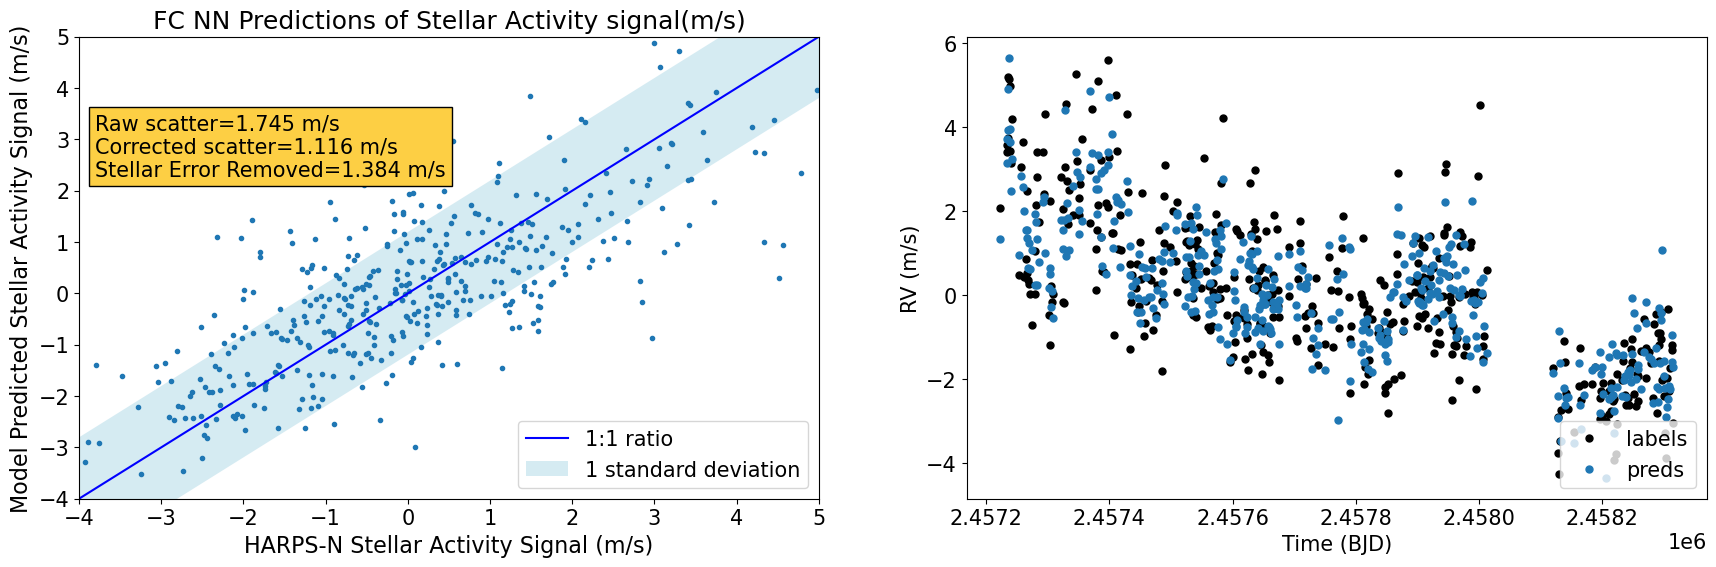

In [102]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_FCNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("FC NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

## CNN Model Run

In [99]:
# CNN Model run

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,10):#0): #should be 10 for a full run
        hparams = configdict.ConfigDict(dict(
            num_features=49,
            learning_rate=0.0085099,#0.0050618, #1e-3,
            momentum=0.9,
            batch_size=300,
            conv_kernel_size=3,
            num_conv_filters=16, #32,
            num_conv_layers=2,#4,
            num_dense_units=100,#500,
            num_dense_layers=1,
            weight_decay=0.0017600,#0.0012341, #5e-4, #7e-2,
            gaussian_noise_scale=0,#1.5,
        ))
        # Initialising the model
        model = CNNModel(hparams)
        
        # Training the model
        train(model, hparams, plots="OFF",model_name="CNN", num_epochs=40)#35)#65)
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())

avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

1: Train loss: 3.552, Train RMSE: 1.909, Val RMSE: 1.417
10: Train loss: 1.609, Train RMSE: 1.199, Val RMSE: 1.107
20: Train loss: 1.172, Train RMSE: 1.08, Val RMSE: 1.204
30: Train loss: 0.9366, Train RMSE: 1.004, Val RMSE: 1.194
40: Train loss: 0.8288, Train RMSE: 0.9166, Val RMSE: 1.226
Raw scatter=1.590 m/s
Corrected scatter=1.226 m/s
Stellar Error Removed=1.013 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.389, Train RMSE: 1.824, Val RMSE: 1.511
10: Train loss: 1.55, Train RMSE: 1.22, Val RMSE: 1.205
20: Train loss: 1.147, Train RMSE: 1.057, Val RMSE: 1.237
30: Train loss: 0.9839, Train RMSE: 0.9798, Val RMSE: 1.161
40: Train loss: 0.7082, Train RMSE: 0.8736, Val RMSE: 1.183
Raw scatter=1.590 m/s
Corrected scatter=1.183 m/s
Stellar Error Removed=1.063 m/s
________________________
Cross-val number: 1, Run number: 2
1: Train loss: 3.228, Train RMSE: 1.882, Val RMSE: 1.78
10: Train loss: 1.457, Train RMSE: 1.182, Val RMSE: 1.652
20: Train loss: 1.29

10: Train loss: 1.421, Train RMSE: 1.211, Val RMSE: 1.168
20: Train loss: 1.143, Train RMSE: 1.113, Val RMSE: 1.051
30: Train loss: 1.025, Train RMSE: 1.026, Val RMSE: 1.05
40: Train loss: 0.764, Train RMSE: 0.9215, Val RMSE: 1.001
Raw scatter=1.846 m/s
Corrected scatter=1.001 m/s
Stellar Error Removed=1.551 m/s
________________________
Cross-val number: 9, Run number: 2
1: Train loss: 3.244, Train RMSE: 1.846, Val RMSE: 1.731
10: Train loss: 1.49, Train RMSE: 1.206, Val RMSE: 1.262
20: Train loss: 1.354, Train RMSE: 1.105, Val RMSE: 1.162
30: Train loss: 1.008, Train RMSE: 1.051, Val RMSE: 1.103
40: Train loss: 1.046, Train RMSE: 0.9712, Val RMSE: 1.063
Raw scatter=1.947 m/s
Corrected scatter=1.063 m/s
Stellar Error Removed=1.631 m/s
________________________
Cross-val number: 10, Run number: 1
1: Train loss: 3.668, Train RMSE: 1.852, Val RMSE: 1.848
10: Train loss: 1.535, Train RMSE: 1.224, Val RMSE: 1.265
20: Train loss: 1.115, Train RMSE: 1.068, Val RMSE: 1.178
30: Train loss: 0.868

labels: sd: 1.8284893255600085
corrected rv: sd: 1.1372950448391559
____________________________________________
labels: MAD*1.4826: 1.7439014172434806
corrected rv: MAD*1.4826: 1.07917177927047
____________________________________________
labels: 68 percent/2: 1.7452754235267638
corrected rv: 68 percent/2: 1.057510571479797


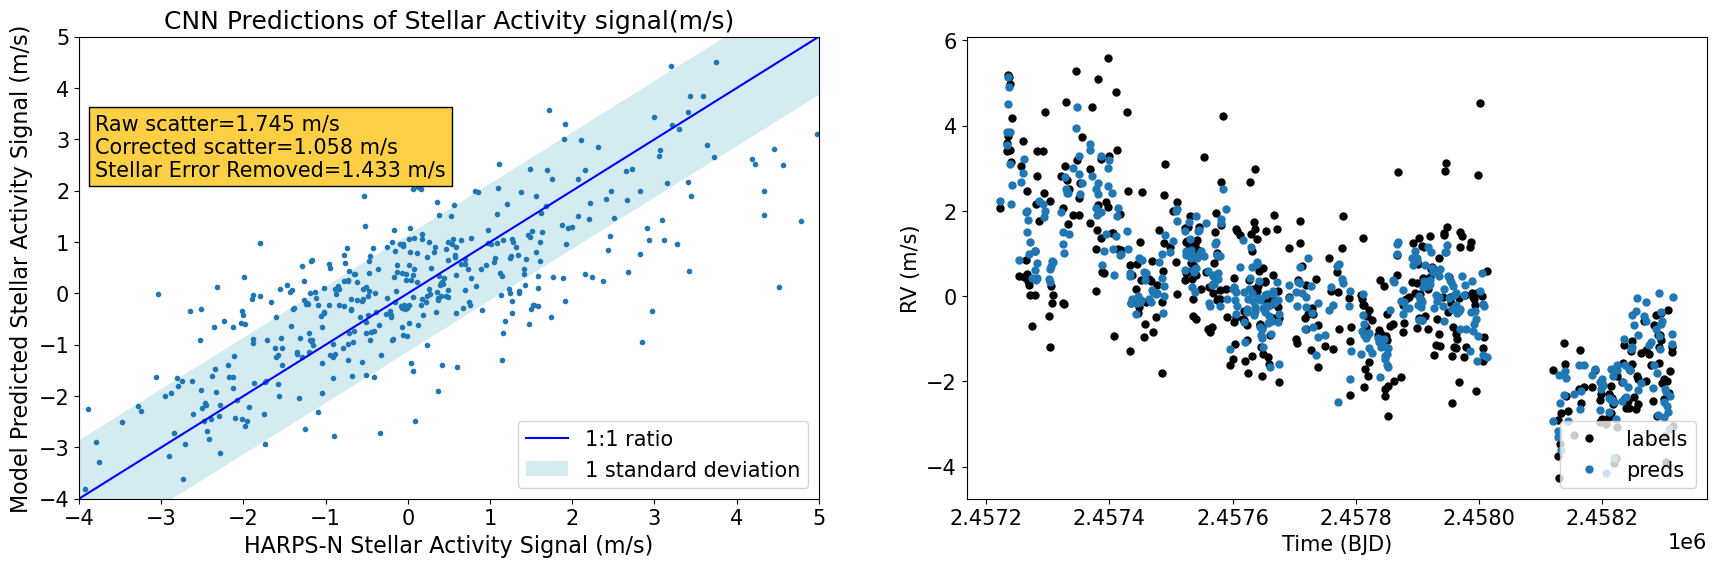

In [100]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")